In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball as pyb
import matplotlib as mpl

In [63]:
# Define font properties for general text
font_properties = {'family': 'DejaVu Sans', 'size': 12}

# Define font properties for titles
font_properties_titles = {'family': 'DejaVu Sans', 'size': 20}

# Define font properties for axes labels
font_properties_axes = {'family': 'DejaVu Sans', 'size': 16}

# Set the theme for seaborn plots
sns.set_theme(style='whitegrid', 
              palette='deep', 
              font='DejaVu Sans', 
              font_scale=1.5, 
              color_codes=True, 
              rc=None)

# Import matplotlib


# Set the resolution of the figures to 300 DPI
mpl.rcParams['figure.dpi'] = 300

In [64]:
import pybaseball as pyb
print(pyb.playerid_lookup('Toglia','Michael'))

  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0    toglia    michael     669911  toglm001  toglimi01          25845   

   mlb_played_first  mlb_played_last  
0            2022.0           2024.0  


In [65]:
print(pyb.playerid_lookup('Cruz','Oneil'))
batter_id = 665833
df_pyb = pyb.statcast_batter('2024-03-28', '2024-10-01', batter_id)
sorted_columns = sorted(df_pyb.columns)
print(sorted_columns)
# df_pyb.head()

  name_last name_first  key_mlbam key_retro key_bbref  key_fangraphs  \
0      cruz      oneil     665833  cruzo001  cruzon01          21711   

   mlb_played_first  mlb_played_last  
0            2021.0           2024.0  
Gathering Player Data
['age_bat', 'age_bat_legacy', 'age_pit', 'age_pit_legacy', 'api_break_x_arm', 'api_break_x_batter_in', 'api_break_z_with_gravity', 'arm_angle', 'at_bat_number', 'away_score', 'away_team', 'ax', 'ay', 'az', 'babip_value', 'balls', 'bat_score', 'bat_score_diff', 'bat_speed', 'bat_win_exp', 'batter', 'batter_days_since_prev_game', 'batter_days_until_next_game', 'bb_type', 'break_angle_deprecated', 'break_length_deprecated', 'delta_home_win_exp', 'delta_pitcher_run_exp', 'delta_run_exp', 'des', 'description', 'effective_speed', 'estimated_ba_using_speedangle', 'estimated_slg_using_speedangle', 'estimated_woba_using_speedangle', 'events', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'fld_scor

In [66]:
# pd.read_csv('BatterDataFG.csv')
# df_fangraphs = pd.read_csv('BatterDataFG.csv')
# print(df_fangraphs.head())

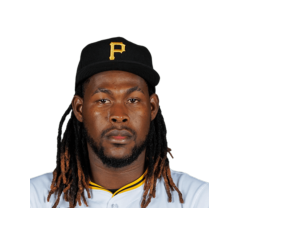

In [67]:
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to get an image from a URL and display it on the given axis
def player_headshot(batter_id: str, ax: plt.Axes):
    # Construct the URL for the player's headshot image
    url = f'https://img.mlbstatic.com/mlb-photos/image/'\
          f'upload/d_people:generic:headshot:67:current.png'\
          f'/w_640,q_auto:best/v1/people/{batter_id}/headshot/silo/current.png'

    # Send a GET request to the URL
    response = requests.get(url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))


    # Display the image on the axis
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0, 1, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')


# Call the player_headshot function with the pitcher ID and current axis
player_headshot(batter_id=batter_id, ax=plt.subplots(figsize=(1, 1))[1])

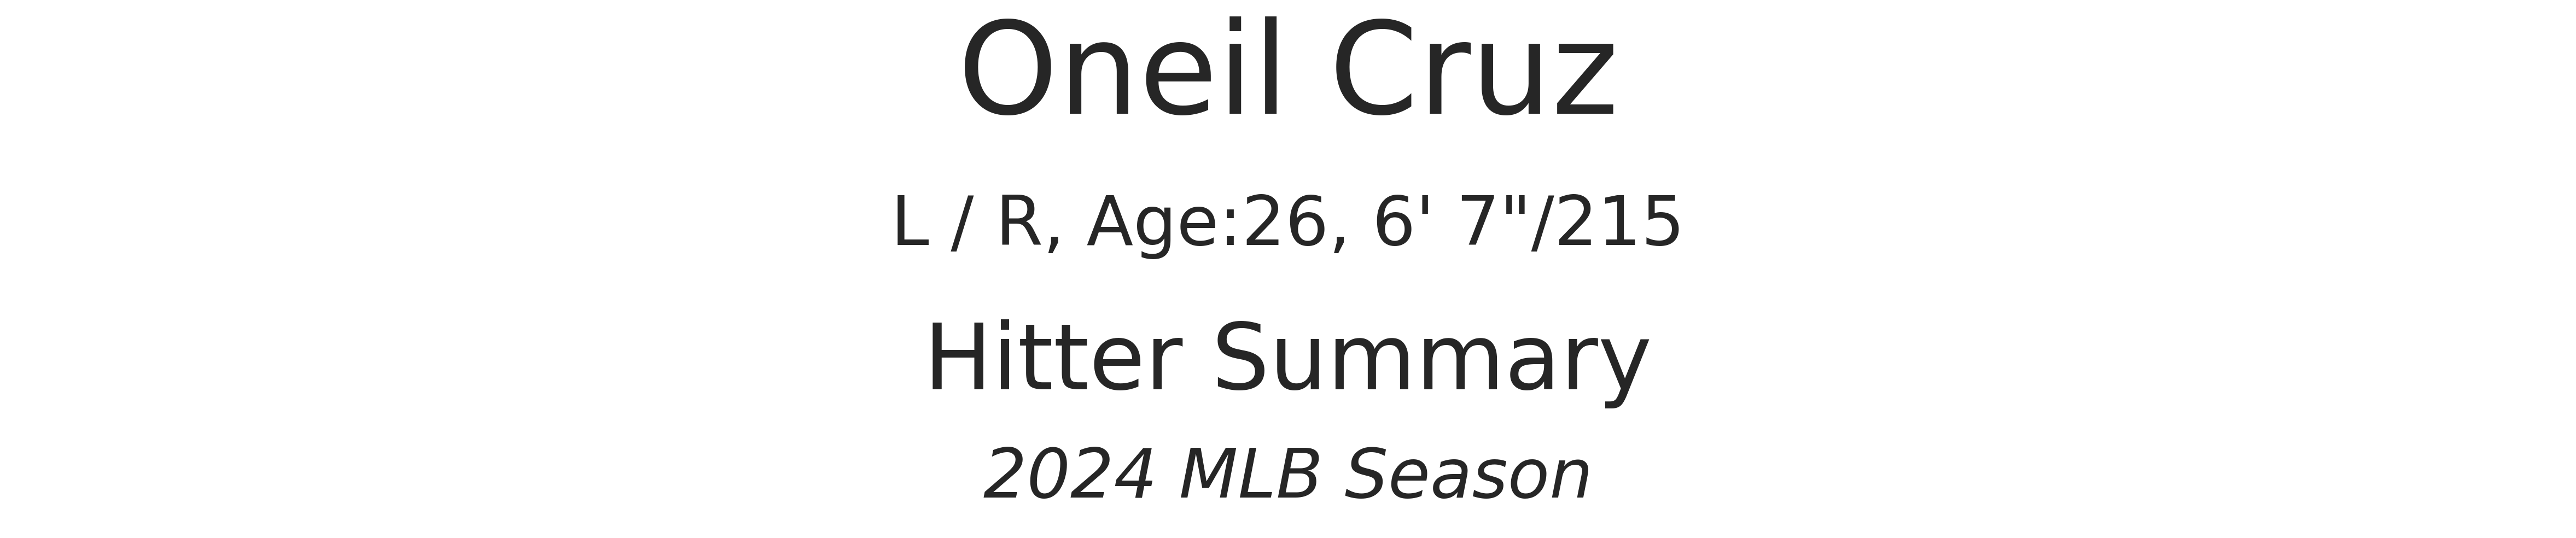

In [68]:
def player_bio(pitcher_id: str, ax: plt.Axes):
    # Construct the URL to fetch player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={pitcher_id}&hydrate=currentTeam"

    # Send a GET request to the URL and parse the JSON response
    data = requests.get(url).json()

    # Extract player information from the JSON data
    player_name = data['people'][0]['fullName']
    batter_throw = data['people'][0]['pitchHand']['code']
    batter_hand = data['people'][0]['batSide']['code']
    age = data['people'][0]['currentAge']
    height = data['people'][0]['height']
    weight = data['people'][0]['weight']

    # Display the player's name, handedness, age, height, and weight on the axis
    ax.text(0.5, 1, f'{player_name}', va='top', ha='center', fontsize=56)
    ax.text(0.5, 0.65, f'{batter_hand} / {batter_throw}, Age:{age}, {height}/{weight}', va='top', ha='center', fontsize=30)
    ax.text(0.5, 0.40, f'Hitter Summary', va='top', ha='center', fontsize=40)
    ax.text(0.5, 0.15, f'2024 MLB Season', va='top', ha='center', fontsize=30, fontstyle='italic')

    # Turn off the axis
    ax.axis('off')

# Call the player_bio function with the pitcher ID and a new axis of size 10x2
player_bio(batter_id, ax=plt.subplots(figsize=(20, 4))[1])

In [69]:
import requests

def fangraphs_batting_leaderboards(season: int):
    url = f"https://www.fangraphs.com/api/leaders/major-league/data?age=&pos=all&stats=bat&lg=all&season={season}&season1={season}&ind=0&qual=0&type=0&month=0&pageitems=500000"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['data'])
    return df

# Example usage:
df_fangraphs = fangraphs_batting_leaderboards(season=2024)
print(df_fangraphs.head())

  Bats  xMLBAMID                                               Name  \
0    R    592450  <a href="statss.aspx?playerid=15640&position=O...   
1    R    677951  <a href="statss.aspx?playerid=25764&position=S...   
2    L    660271  <a href="statss.aspx?playerid=19755&position=D...   
3    L    665742  <a href="statss.aspx?playerid=20123&position=O...   
4    L    683002  <a href="statss.aspx?playerid=26289&position=3...   

                                                Team  Season   Age     AgeR  \
0  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  32.0  32 - 32   
1  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  24.0  24 - 24   
2  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  29.0  29 - 29   
3  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  25.0  25 - 25   
4  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  23.0  23 - 23   

   SeasonMin  SeasonMax      G  ...     TG    TPA   PlayerNameRoute  \
0       2024       2024  15

       G     PA      AVG       OBP       SLG       OPS       ISO       WAR
0  146.0  599.0  0.25878  0.323873  0.449168  0.773041  0.190388  3.515289


C:\Users\Jackson\AppData\Local\Temp\ipykernel_21456\2306637525.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '146' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0],fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
C:\Users\Jackson\AppData\Local\Temp\ipykernel_21456\2306637525.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '599' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0],fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
C:\Users\Jackson\AppData\Local\Temp\ipykernel_21456\2306637525.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an

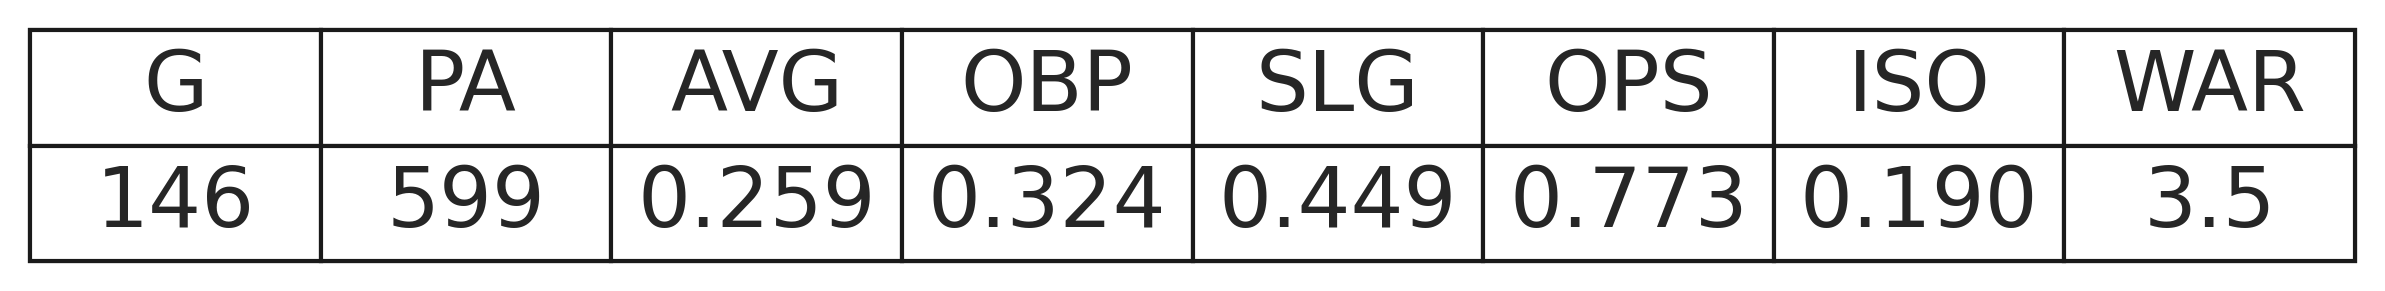

In [70]:
from matplotlib import font_manager

fangraphs_stats_dict = {
    'G': {'table_header': '$\\bf{G}$', 'format': '.0f'},         # Integer
    'PA': {'table_header': '$\\bf{PA}$', 'format': '.0f'},        # Integer
    'wOBA': {'table_header': '$\\bf{wOBA}$', 'format': '.3f'},     # Float (3 decimals)
    'wRC+': {'table_header': '$\\bf{wRC+}$', 'format': '.0f'},     # Integer (rounded)
    'AVG': {'table_header': '$\\bf{AVG}$', 'format': '.3f'},       # Float (3 decimals)
    'OBP': {'table_header': '$\\bf{OBP}$', 'format': '.3f'},       # Float (3 decimals)
    'SLG': {'table_header': '$\\bf{SLG}$', 'format': '.3f'},       # Float (3 decimals)
    'OPS': {'table_header': '$\\bf{OPS}$', 'format': '.3f'},       # Float (3 decimals)
    'WAR': {'table_header': '$\\bf{WAR}$', 'format': '.1f'},
    'ISO': {'table_header': '$\\bf{ISO}$', 'format': '.3f'},
}

def fangraphs_batter_stats(batter_id: int, ax: plt.Axes, stats: list, season: int, fontsize: int = 20):
    df_fangraphs = fangraphs_batting_leaderboards(season=season)

    df_fangraphs_batter = df_fangraphs[df_fangraphs['xMLBAMID'] == batter_id][stats].reset_index(drop=True)
    print(df_fangraphs_batter)
        
    df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0],fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
    
    
    table_fg = ax.table(cellText=df_fangraphs_batter.values, colLabels=stats, cellLoc='center',
                    bbox=[0.00, 0.0, 1, 1])
    # Create the table
    table_fg = ax.table(cellText=df_fangraphs_batter.values, colLabels=stats, cellLoc='center', bbox=[0.00, 0.0, 1, 1])

    # Set font size for each cell's text
    for key, cell in table_fg.get_celld().items():
        if cell._text:
            cell._text.set_fontsize(fontsize)

    ax.axis('off')

stats = ['G','PA','AVG','OBP','SLG','OPS','ISO','WAR']
fangraphs_batter_stats(batter_id = batter_id,
                        ax = plt.subplots(figsize=(10, 1))[1],
                        stats = stats,
                        season = 2024)

In [71]:
print(batter_id)
stats = ['Name', 'Age', 'Team', 'G', 'PA', 'wOBA', 'wRC+','AVG','OBP','SLG','OPS']
batter_df = df_fangraphs[df_fangraphs['xMLBAMID'] == batter_id][stats].reset_index(drop=True)
print(batter_df)


665833
                                                Name   Age  \
0  <a href="statss.aspx?playerid=21711&position=S...  25.0   

                                                Team      G     PA      wOBA  \
0  <a href="leaders.aspx?pos=all&stats=bat&lg=all...  146.0  599.0  0.331016   

         wRC+      AVG       OBP       SLG       OPS  
0  109.876358  0.25878  0.323873  0.449168  0.773041  


In [72]:
# Retrieve the Fangraphs data for inspection
df_fangraphs = fangraphs_batting_leaderboards(season=2024)

# Check the first few rows and column data types
print(df_fangraphs.head())
print(df_fangraphs.dtypes)

  Bats  xMLBAMID                                               Name  \
0    R    592450  <a href="statss.aspx?playerid=15640&position=O...   
1    R    677951  <a href="statss.aspx?playerid=25764&position=S...   
2    L    660271  <a href="statss.aspx?playerid=19755&position=D...   
3    L    665742  <a href="statss.aspx?playerid=20123&position=O...   
4    L    683002  <a href="statss.aspx?playerid=26289&position=3...   

                                                Team  Season   Age     AgeR  \
0  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  32.0  32 - 32   
1  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  24.0  24 - 24   
2  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  29.0  29 - 29   
3  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  25.0  25 - 25   
4  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  23.0  23 - 23   

   SeasonMin  SeasonMax      G  ...     TG    TPA   PlayerNameRoute  \
0       2024       2024  15

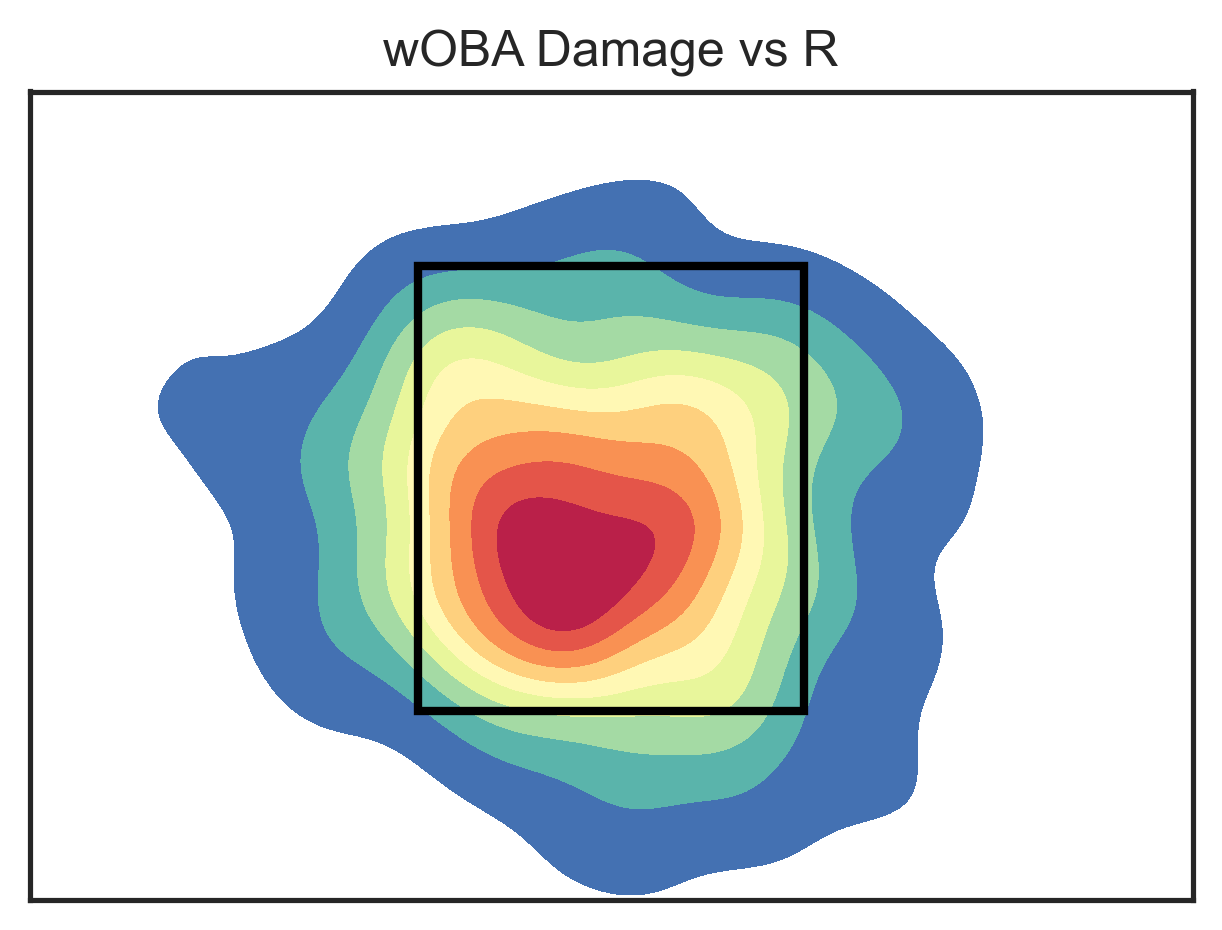

In [110]:
import matplotlib.patches as patches

filtered_R_df = df_pyb[(df_pyb['plate_x'].notnull()) & (df_pyb['plate_z'].notnull()) & (df_pyb['woba_value'].notnull()) & (df_pyb['p_throws'] == 'R')]


plate_damage_df = pd.DataFrame({
    'plate_x': filtered_R_df['plate_x'],
    'plate_z': filtered_R_df['plate_z'],
    'damage': filtered_R_df['woba_value']
})

# Define the corner coordinates for the rectangle
min_plate_x = -0.83
max_plate_x = 0.83
min_plate_z = 1.17
max_plate_z = 3.92

# Create the heatmap (you can use hexbin or kdeplot as shown earlier)
plt.figure(figsize=(5, 3.5))

# KDE plot with plate_x and plate_z as the axes, and damage as the color
sns.kdeplot(data=plate_damage_df, x='plate_x', y='plate_z', cmap='Spectral_r', fill=True, cbar=False, bw_adjust=.9)

# Create a rectangle using the given corner coordinates
rectangle = patches.Rectangle(
    (min_plate_x, min_plate_z),  # Lower left corner
    max_plate_x - min_plate_x,   # Width
    max_plate_z - min_plate_z,   # Height
    linewidth=2,                 # Line width
    edgecolor='black',             # Rectangle border color
    facecolor='none',            # No fill color inside the rectangle
    linestyle='-'               # Dotted line style
)

plt.gca().add_patch(rectangle)
plt.xlim(-2.5, 2.5)
plt.ylim(0,5)
plt.xticks([])  # Remove x-axis numbers
plt.yticks([])  # Remove y-axis numbers
plt.grid(False)
# Optionally, remove spines for a cleaner look
sns.set(style="white")

# Add labels and title
plt.title("wOBA Damage vs R")
plt.xlabel("")
plt.ylabel("")

# Show the plot
plt.show()

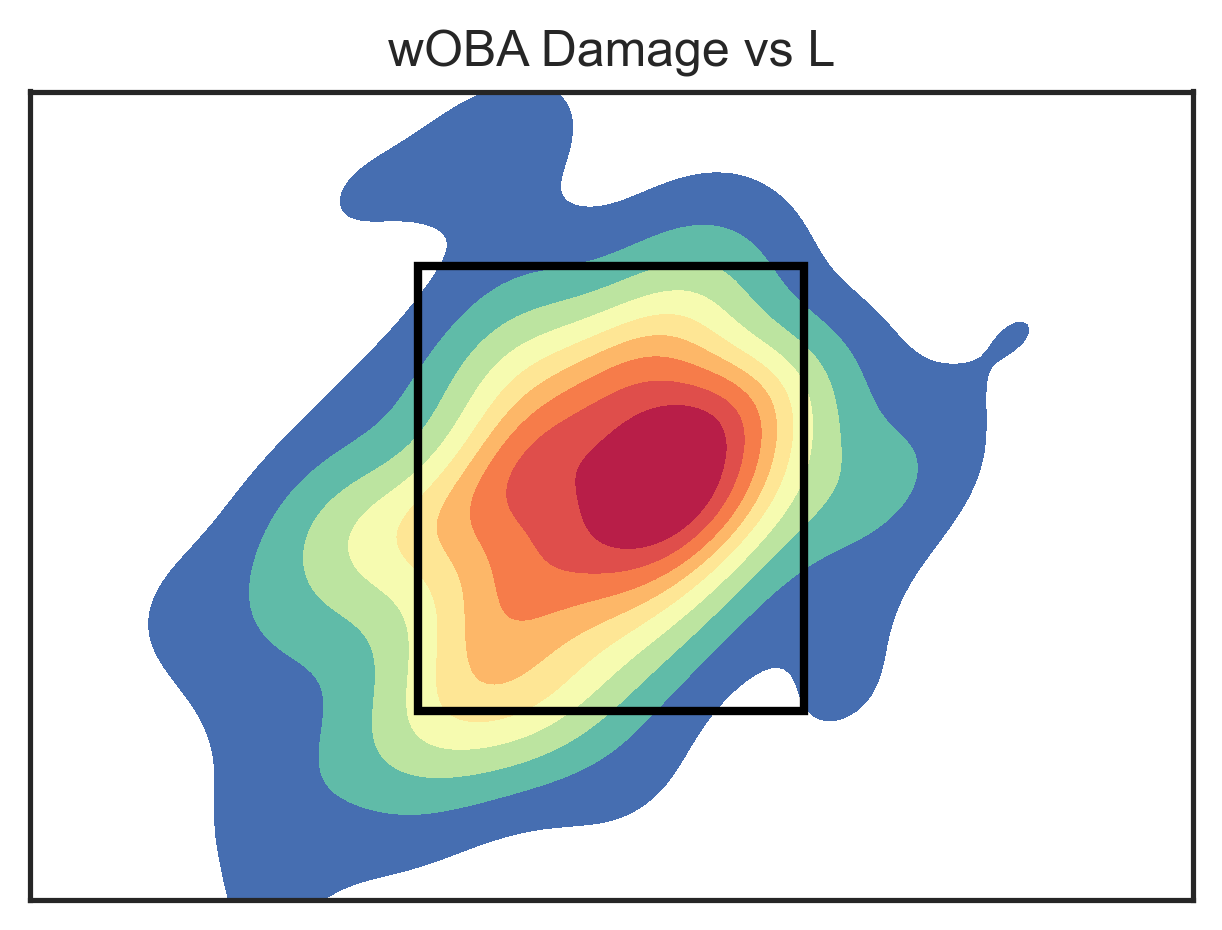

In [111]:

import matplotlib.patches as patches

filtered_L_df = df_pyb[(df_pyb['plate_x'].notnull()) & (df_pyb['plate_z'].notnull()) & (df_pyb['woba_value'].notnull()) & (df_pyb['p_throws'] == 'L')]


plate_damage_df = pd.DataFrame({
    'plate_x': filtered_L_df['plate_x'],
    'plate_z': filtered_L_df['plate_z'],
    'damage': filtered_L_df['woba_value']
})

# Define the corner coordinates for the rectangle
min_plate_x = -0.83
max_plate_x = 0.83
min_plate_z = 1.17
max_plate_z = 3.92

# Create the heatmap (you can use hexbin or kdeplot as shown earlier)
plt.figure(figsize=(5, 3.5))

# KDE plot with plate_x and plate_z as the axes, and damage as the color
sns.kdeplot(data=plate_damage_df, x='plate_x', y='plate_z', cmap='Spectral_r', fill=True, cbar=False, bw_adjust=.9)

# Create a rectangle using the given corner coordinates
rectangle = patches.Rectangle(
    (min_plate_x, min_plate_z),  # Lower left corner
    max_plate_x - min_plate_x,   # Width
    max_plate_z - min_plate_z,   # Height
    linewidth=2,                 # Line width
    edgecolor='black',             # Rectangle border color
    facecolor='none',            # No fill color inside the rectangle
    linestyle='-'               # Dotted line style
)

plt.gca().add_patch(rectangle)
plt.xlim(-2.5, 2.5)
plt.ylim(0,5)
plt.xticks([])  # Remove x-axis numbers
plt.yticks([])  # Remove y-axis numbers
plt.grid(False)
# Optionally, remove spines for a cleaner look
sns.set(style="white")

# Add labels and title
plt.title("wOBA Damage vs L")
plt.xlabel("")
plt.ylabel("")

# Show the plot
plt.show()


C:\Users\Jackson\AppData\Local\Temp\ipykernel_21456\2796531649.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm')  # Use a diverging colormap


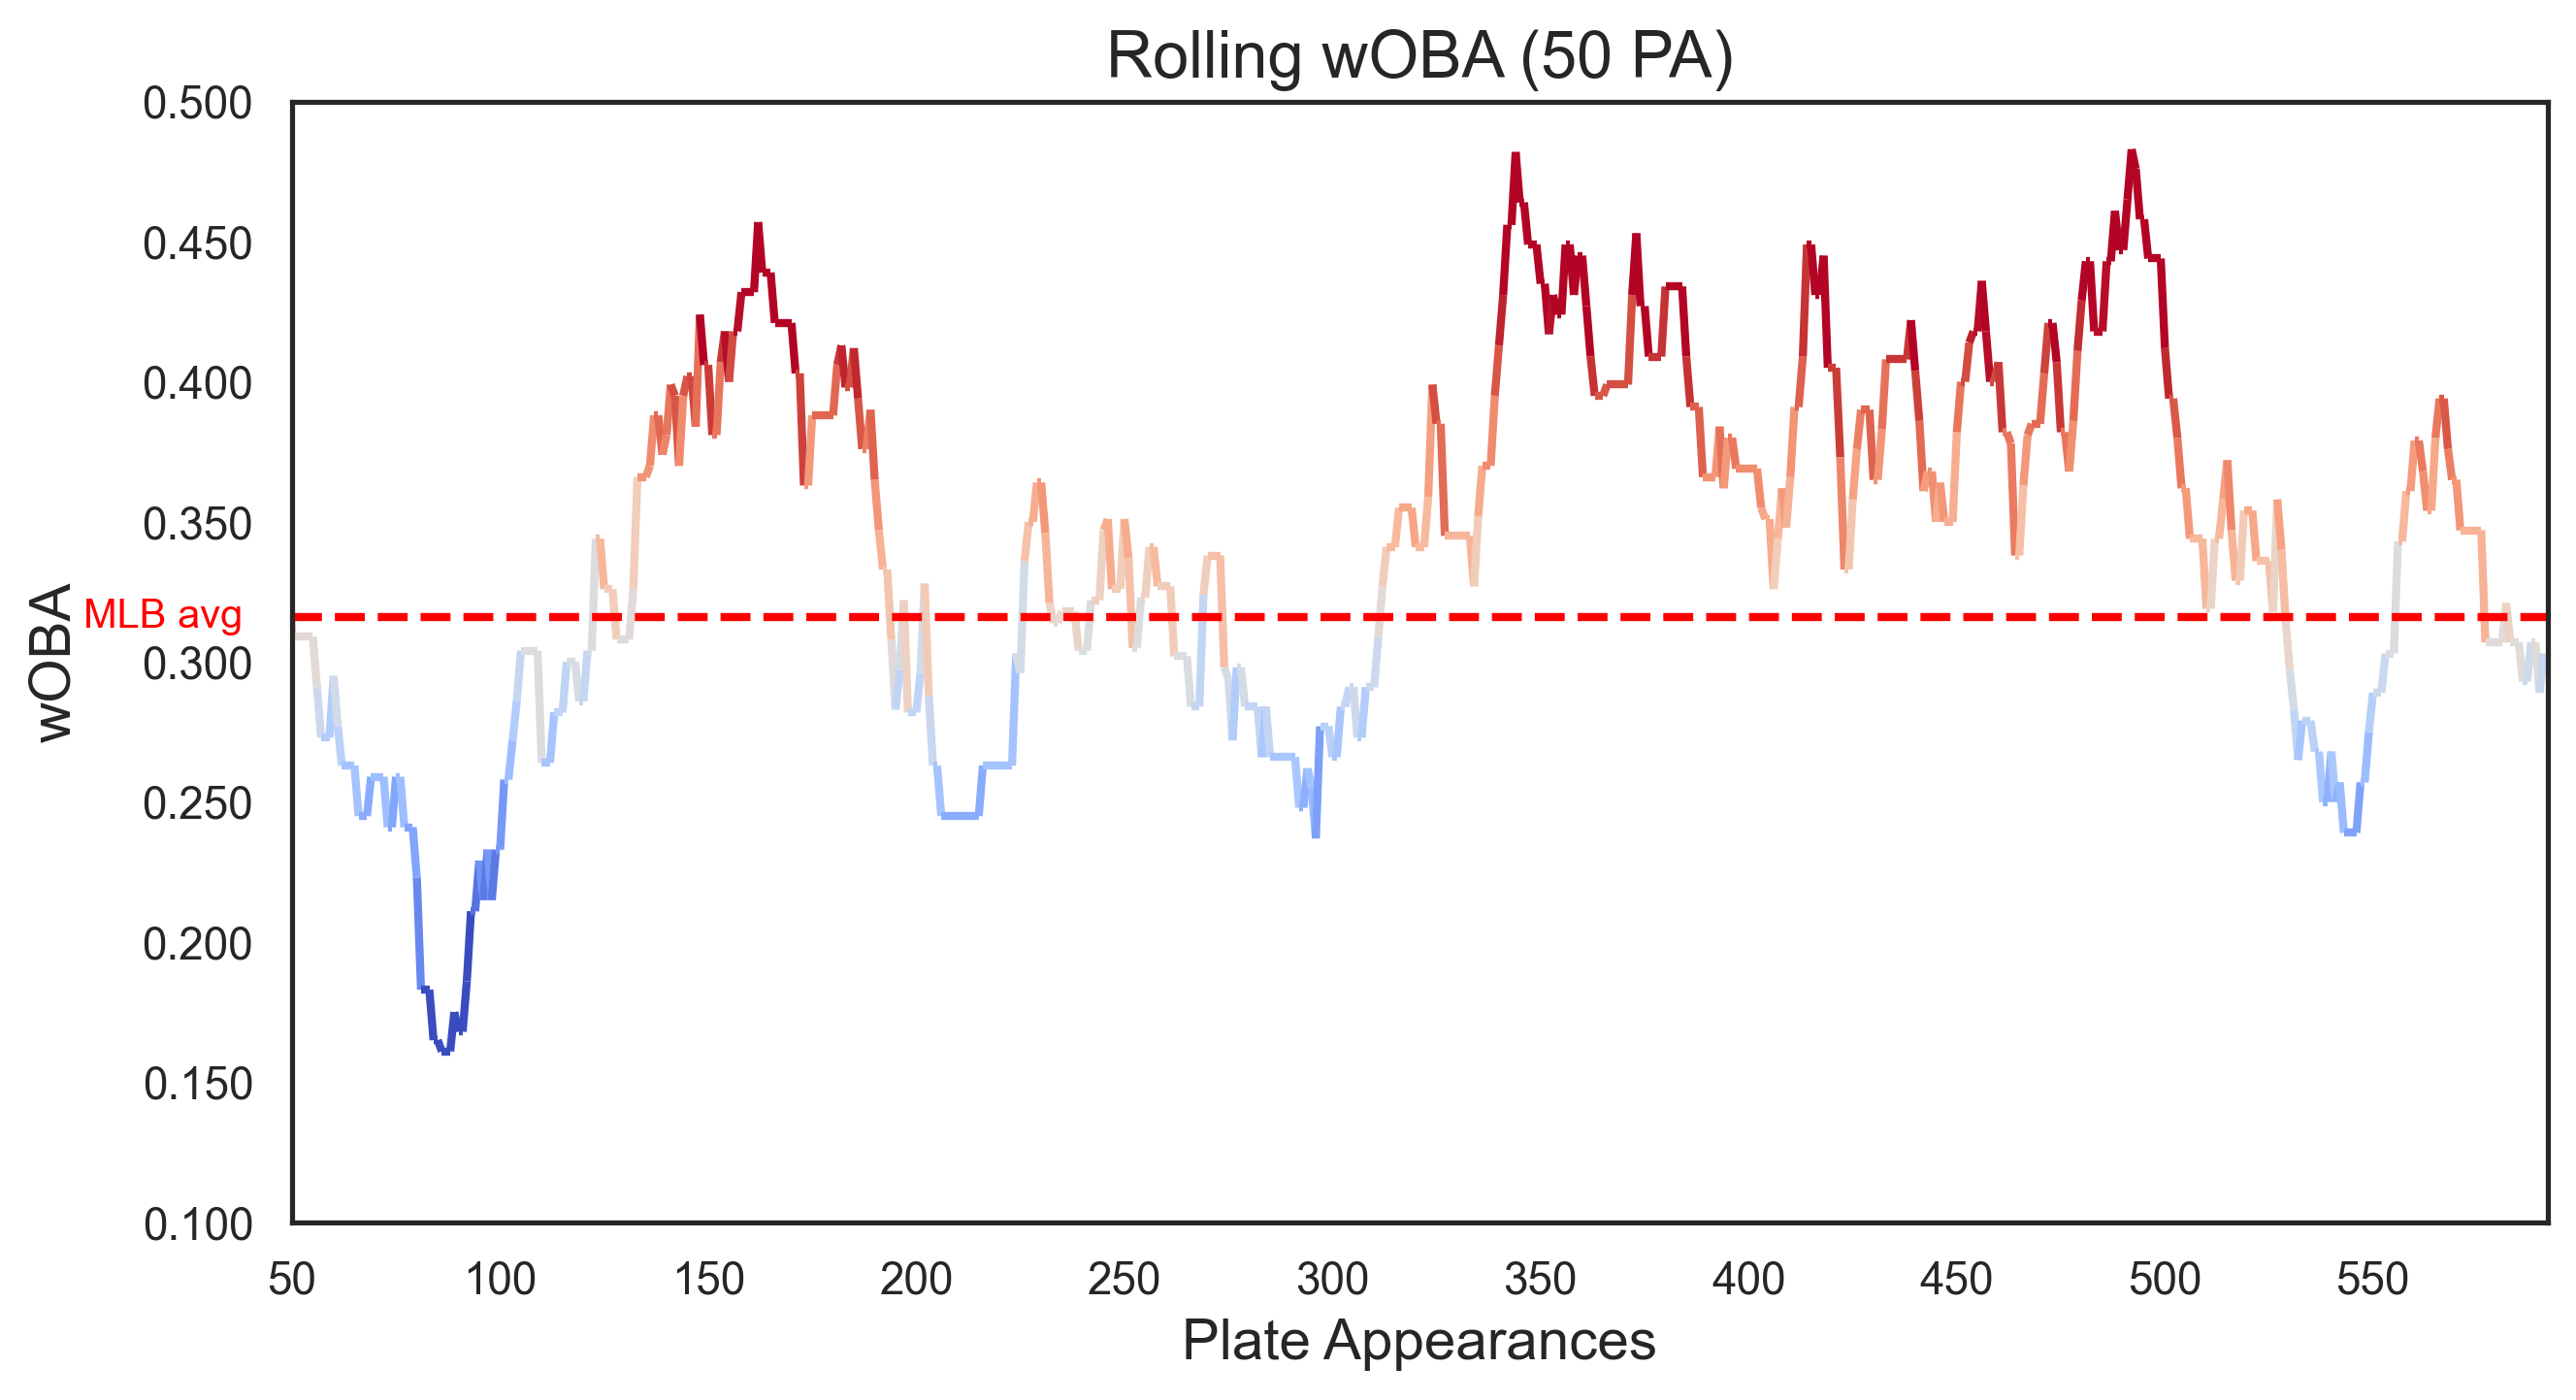

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection

def rolling_woba_by_pa(df: pd.DataFrame, ax: plt.Axes, window: int):
    # Drop rows where 'woba_value' or 'plate_x' and 'plate_z' are NaN
    df = df.dropna(subset=['woba_value', 'plate_x', 'plate_z'])

     # Reverse the DataFrame order
    df = df.iloc[::-1].reset_index(drop=True)
    
    # Calculate wOBA rolling window by PA (plate appearance)
    df['rolling_woba'] = df['woba_value'].rolling(window=window).mean()
    
    # Generate x and y data for the plot
    x = np.arange(len(df))
    y = df['rolling_woba'].values

    # Create segments for the LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Define color based on the y value crossing the 0.316 threshold
    colors = ['blue' if y_ < 0.316 else 'red' for y_ in y]
    cmap = plt.cm.get_cmap('coolwarm')  # Use a diverging colormap
    lc = LineCollection(
        segments, 
        cmap=cmap, 
        norm=plt.Normalize(vmin=0.19, vmax=0.42),  # Adjust normalization as needed
        linewidth=2
    )
    lc.set_array(y)  # Color by y-values
    ax.add_collection(lc)

    # Plot the rolling wOBA against Plate Appearances
    ax.plot(x, y, alpha=0)  # Transparent line for proper scaling
    
    # Adjust axis labels and title
    ax.set_xlabel('Plate Appearances', fontdict={'size': 14})
    ax.set_ylabel('wOBA', fontdict={'size': 14})
    ax.set_title(f'Rolling wOBA ({window} PA)', fontdict={'size': 16})

    # Move y-axis label to avoid overlap
    ax.set_ylabel('wOBA', fontdict={'size': 14}, labelpad=15)  # Adjust `labelpad` for spacing
    
    # Format y-axis to show three decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Set x-axis to show integer values only (i.e., PA numbers)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.set_xticks(np.arange(0, len(df), 50))

    # Optional: Adjust x and y axis limits
    ax.set_xlim(50, len(df))  # Set x-axis range from 0 to the length of the data
    ax.set_ylim(.1, 0.500)      # Example: limit y-axis to range from 0 to 0.5 for rolling wOBA
    
    # Add dashed red line at y = 0.316 (MLB average)
    ax.axhline(y=0.316, color='red', linestyle='--', linewidth=2)
    
    # Add label for the dashed line
    ax.text(0, 0.316, 'MLB avg', color='red', fontsize=10, va='center', ha='left')

    plt.show()

filtered_df = df_pyb[(df_pyb['events'].notnull())]
# Example usage
rolling_woba_by_pa(filtered_df, ax=plt.subplots(figsize=(10, 5))[1], window=50)


In [113]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def hitting_dashboard(batter_id: str, df: pd.DataFrame, stats: list):
    # Create a 20 by 20 figure
    df = df_processing(df)
    fig = plt.figure(figsize=(20, 20))

    # Create a gridspec layout with 8 columns and 6 rows
    # Include border plots for the header, footer, left, and right
    gs = gridspec.GridSpec(6, 8,
                        height_ratios=[2,20,9,36,36,7],
                        width_ratios=[1,18,18,18,18,18,18,1])

    # Define the positions of each subplot in the grid
    ax_headshot = fig.add_subplot(gs[1,1:3])
    ax_bio = fig.add_subplot(gs[1,3:5])
    ax_logo = fig.add_subplot(gs[1,5:7])

    ax_season_table = fig.add_subplot(gs[2,1:7])

    ax_plot_1 = fig.add_subplot(gs[3,1:3])
    ax_plot_2 = fig.add_subplot(gs[3,3:5])
    ax_plot_3 = fig.add_subplot(gs[3,5:7])

    ax_table = fig.add_subplot(gs[4,1:7])

    ax_footer = fig.add_subplot(gs[-1,1:7])
    ax_header = fig.add_subplot(gs[0,1:7])
    ax_left = fig.add_subplot(gs[:,0])
    ax_right = fig.add_subplot(gs[:,-1])

    # Hide axes for footer, header, left, and right
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    fangraphs_batter_stats(batter_id = batter_id,
                        ax = plt.subplots(figsize=(10, 1))[1],
                        stats = stats,
                        season = 2024)

    player_headshot(batter_id, ax=ax_headshot)
    player_bio(batter_id, ax=ax_bio)
    plot_logo(batter_id, ax=ax_logo)

    
    rolling_woba_by_pa(filtered_df, ax=plt.subplots(figsize=(10, 5))[1], window=50)


     # Add footer text
    ax_footer.text(0, 1, 'By: @JLukeSports', ha='left', va='top', fontsize=24)
    ax_footer.text(0.5, 1, 'Colour Coding Compares to League Average', ha='center', va='top', fontsize=16)
    ax_footer.text(1, 1, 'Data: MLB, Fangraphs\nImages: MLB, ESPN', ha='right', va='top', fontsize=24)

    plt.tight_layout()
    plt.show()

    stats = ['G','PA','AVG','OBP','SLG','OPS','ISO','WAR']
    pitcher_id = 669373
    df_pyb = pyb.statcast_batter('2024-03-28', '2024-10-01', batter_id)

hitting_dashboard(batter_id, df_pyb, stats)

NameError: name 'df_processing' is not defined